# Data Science Project- Akiva Kleinerman


This notebook will demonstrate how to use the code in my project and show an example of the output. 

The outputs will be found in the notebook itself and also in the "output" folder in the notebook files 

### Initial Steps 

First, we will import and add a few configurations (from the Configuration file).

In this project, we use XGBoost for both classification and regression problems. We do not compare between XGBoost and other models, neither experiment it's hyper-parameters, because this is not the focus of our project

In [12]:
from xgboost import XGBRegressor, XGBClassifier



REGRESSIOM_MODEL= XGBRegressor(use_label_encoder =False,verbosity = 0)
CLASSIFICATION_MODEL= XGBClassifier(use_label_encoder =False,verbosity = 0)
TREATMENT_METHODS=["drop", "median_replaced", "capped_floored"]
UNIVARIATE_DETECTION_METHODS=["mad", "percentile", "iqr"]

#Number of folds- this defines the number of folds. The test set's size is 1/FOLD_K of the original dataset
FOLD_K= 6

In [13]:

# evaluate model performance with outliers removed using isolation forest

import os
import time


In [14]:
# create a directory for the results and create files for the output
outdir = os.getcwd() + '/output/' + str(time.time())
if not os.path.exists(outdir):
    os.umask(0)
    os.makedirs(outdir)
f = open(outdir + '/results.csv', 'w')
f2 = open(outdir + '/iterations.csv', 'w')

**K-Fold flag:**  This variable is a binary flag- indicating if we use k-fold. In this notebook- for limiting runtime we do **not** use k-fold cross-validation . But using k fold is recommended, and the default in the github code

In [15]:
# A binary flag- when True- use K-fold, otherwise only run once (on first fold)
USE_K_FOLD= False

# Univariate Outlier Detection Methods
Here we implement three common and basic methods for detecting univariate outliers : 1) median absoulute deviation 2)  percentile based 3) IQR based. 
We use constant common thresholds, defined below

In [16]:
IQR_THRESHOLD=1.5
PERCENTILE_THRESHOLD= 99
MAD_THRESHOLD= 3.5


def mad_based_outlier(data, thresh=MAD_THRESHOLD):
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        if len(data.shape) == 1:
            data = data[:, None]
        median = np.median(data, axis=0)
        diff = np.sum((data - median) ** 2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)
        if(med_abs_deviation==0):
            med_abs_deviation=0.1 #todo- wanted to avoid division by zero, dirty- need to think why this happens
        modified_z_score = 0.6745 * diff / med_abs_deviation
        return modified_z_score < thresh


def percentile_based_outlier(data, threshold=PERCENTILE_THRESHOLD):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return list((data > minval) | (data < maxval))


def univariate_outlier_mask(data, method):
    if(method== "mad"):
        return mad_based_outlier(data)
    elif(method== "percentile"):
        return percentile_based_outlier(data)
    elif(method== "iqr"):
        return iqr_anomaly_detector(data)


def iqr_anomaly_detector(data, threshold=IQR_THRESHOLD):
    def find_anomalies(value, lower_threshold, upper_threshold):
        if value < lower_threshold or value > upper_threshold:
            return False
        else:
            return True
    quartiles = dict(data.quantile([.25, .50, .75]))
    quartile_3, quartile_1 = quartiles[0.75], quartiles[0.25]
    iqr = quartile_3 - quartile_1
    lower_threshold = quartile_1 - (threshold * iqr)
    upper_threshold = quartile_3 + (threshold * iqr)
    #print(f"Lower threshold_factor: {lower_threshold}, \nUpper threshold_factor: {upper_threshold}\n")
    return list(data.apply(find_anomalies, args=(lower_threshold, upper_threshold)))

# Multivariate Outlier Detection Methods

In [17]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
# Data processing
# Model
from sklearn.mixture import GaussianMixture

# the function receives a train set and returns a dictionary including filtering masks of
# the data according to various multivariate outlier detection methods
def identify_multivariate_outliers(X_train):
    outlier_models= {"isolation forest": IsolationForest(contamination=0.1),"ellipicit_envelope":EllipticEnvelope(contamination=0.01),
                     "local outlier factor": LocalOutlierFactor(), "one class svm": OneClassSVM(nu=0.01)}
    outlier_masks={}
    for model_name in outlier_models:
        yhat = outlier_models[model_name].fit_predict(X_train)
        # select all rows that are not outliers
        mask = yhat != -1
        outlier_masks[model_name]= mask
    outlier_masks["guassian_model"]= guassian_mixtures_based_outlier_detection(X_train)
    return outlier_masks

"""
This function uses the Gussian mixture model in order to find clusters of (multi-dimensional) data. 
The smales that are furthest from the clusters are marked as outliers 
"""
def guassian_mixtures_based_outlier_detection(X_train, threshold_factor=5):
    # create GMM model
    gmm = GaussianMixture(n_components=3, n_init=5, random_state=42)
    # Fit and predict on the data
    gmm.fit_predict(X_train)
    #  Predict Anomalies Using Percentage Threshold
    score = gmm.score_samples(X_train)
    # Get the score threshold_factor for anomaly
    pct_threshold = np.percentile(score, threshold_factor)
    mask = score > pct_threshold
    return mask

# Univariate Outlier Treatment

Here we implement two common and basic methods for *treating* univariate outliers : 1) replacing by median 2) flooring and capping

In [18]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

def replace_outlier_by_median(df, column, outlier):
    new_df= df
    median= df[column].median()
    #df.loc[[~b for b in outlier], column] = median
    #df[column] = np.where([~b for b in outlier], median, df[column])
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        new_df[column]= new_df[column].where(outlier, other=median)
    return new_df


def replace_outlier_by_flooring_and_capping(df, column, outlier, min_percentile=0.01, top_percentile= 0.99):
    median= df[column].median()
    temp_df= df
    temp_df["outlier"]= outlier
    percentiles = df[column].quantile([min_percentile, top_percentile]).values
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        temp_df[column][(temp_df[column] > median ) & (temp_df ["outlier"]== False)]= percentiles[0]
        temp_df[column][(temp_df[column] < median ) & (temp_df ["outlier"]== False)]= percentiles[1]
    return temp_df.drop(["outlier"], axis=1)


def get_treated_datasets(X_train_copy, col, outlier_mask, y_train_copy, treatment_methods= ["drop", "median", "floored_and_capped"]):
    new_datasets_dict={}
    if("drop" in treatment_methods):
        X_train_masked, y_train_masked = X_train_copy.iloc[outlier_mask, :], y_train_copy.iloc[outlier_mask]
        new_datasets_dict["drop"]= [X_train_masked, y_train_masked]
    if("median" in treatment_methods):
        X_train_median_replaced = replace_outlier_by_median(X_train_copy.copy(), col, outlier_mask)
        new_datasets_dict["median"]= [X_train_median_replaced, y_train_copy]
    if("floored_and_capped" in treatment_methods):
        X_train_capped_and_floored = replace_outlier_by_flooring_and_capping(X_train_copy.copy(), col, outlier_mask)
        new_datasets_dict["floored_and_capped"]= [X_train_capped_and_floored, y_train_copy]
    # if (detection_method == "percentile"):
    #     X_train_capped = quantile_based_flooring_and_capping(X_train_copy, col)
    #     new_datasets_dict["capped_floored"] = [X_train_capped, y_train_copy]
    #     # summarize the shape of the updated training dataset
    return new_datasets_dict

## A few more general helper functions

In [19]:

"""
The function splits the dataset in samples and labels 
the name of the label may be in the metadata (Configuration file)
by default- we assume it is the last column

input: df- the dataframe (pandas), info- the metadata
output- X,y - two dataframes 
"""
def split_into_X_and_y(df, info):
    if "label" in info:
        return df.drop([info["label"]], axis=1), df[info["label"]]
    else:
        return df[list(df.columns)[:-1]], df[list(df.columns)[-1]]



def accuracy_was_improved(best_accuracy_for_col, best_accuracy_for_round, best_accuracy_global, IS_REGRESSION):
    if (IS_REGRESSION and best_accuracy_for_col < best_accuracy_global and best_accuracy_for_col < best_accuracy_for_round) :
        return True
    if(not IS_REGRESSION and best_accuracy_for_col > best_accuracy_global and best_accuracy_for_col > best_accuracy_for_round):
        return True
    return False


def get_best_result(col_results, IS_REGRESSION):
    if IS_REGRESSION:
        return min(enumerate(col_results.values()),key=itemgetter(1))
    else:
        return max( enumerate(col_results.values()), key=itemgetter(1))


"""
The function gets a dataset and  one column from the dataset, with the column's outliers and the expected treatment
The function returns that the dataset after treating the outlier 
"""
def treat_best_column(X_train_copy, best_column_treatment, col, outlier_mask, y_train_copy):
    if (best_column_treatment == "drop"):
        X_train_copy, y_train_copy = X_train_copy.iloc[outlier_mask, :], y_train_copy.iloc[
            outlier_mask]
    elif (best_column_treatment == "median"):
        X_train_copy = replace_outlier_by_median(X_train_copy.copy(), col, outlier_mask)
    else:
        X_train_copy = replace_outlier_by_flooring_and_capping(X_train_copy.copy(), col, outlier_mask)
    return X_train_copy, y_train_copy


def evaluate_regression_model(predictions,y_test):
    return mean_absolute_error(predictions, y_test)


# Evaluate the classifcation model and return the AUC, precision and recall 
def evaluate_classification_model(predictions,y_test):
    precision_w = precision_score(y_test, predictions, average='weighted')
    recall_w = recall_score(y_test, predictions, average='weighted')
    auc= roc_auc_score(y_test, predictions)
    return auc, precision_w, recall_w

# A simple imputer for missing data. Meanwhile using mean imputation
def impute(df):
    simple_imputer = SimpleImputer(strategy="mean", missing_values=np.nan)
    imputed_df= pd.DataFrame(simple_imputer.fit_transform(df))
    imputed_df.columns = df.columns
    imputed_df.index = df.index
    return  imputed_df



"""
The function get a dataset, after splitting to train-test and a prediction model
 The function fits and  evaluates the model with the given dataset and returns the accuracy
  
"""
def fit_model_and_evaluate_accuracy( X_train,y_train,  X_test,y_test, model, IS_REGRESSION):
    # fit the model
    model.fit(X_train, y_train)
    # evaluate the model
    yhat = model.predict(X_test)
    # evaluate predictions
    if (IS_REGRESSION):
        accuracy = evaluate_regression_model(yhat, y_test)
    else:
        auc, precision, recall = evaluate_classification_model(yhat, y_test)
        accuracy = auc
    return accuracy


# The Iterative Univariate Outlier Process
the main function
The function iteratively finds the best columns to treat and then performs the outlier treatments. For each column- the function tries all combinations of detection and treatment functions. See the article for the psuedo code and  more details

In [20]:

""""
univariate outliers treatment 

The function implements the Iterative Univaraite Outlier Process
Input:
The function recieves the dataset divided into train and test (X_train, X_test, y_train, y_test,)
In 

"""
def univariate_outliers(X_train, X_test, y_train, y_test, columns, model, IS_REGRESSION,
                        outlier_detecting_methods=["mad", "percentile", "iqr"],
                        outlier_treating_methods=["drop", "median", "floored_and_capped"]):

    filtered_columns_dict = {}
    filtered_col = []
    improved_flag = True
    # best_accuracy_global- the best accuracy found in all iterations
    best_accuracy_global = np.infty if IS_REGRESSION else 0
    X_train_copy, y_train_copy = X_train, y_train
    # The main iteration loop: as long as their are more columns to try filtering, and as long a the previous iteration improved
    iteration_n= 1
    while len(filtered_col) < len(columns) and improved_flag:
        # best_accuracy_for_round- the best accuracy in the current iteration
        print("iteration  #"+ str(iteration_n)+ " --->")
        best_accuracy_for_round = np.infty if IS_REGRESSION else 0
        best_col = None
        improved_flag = False
        for col in [c for c in columns if c not in filtered_col]:
            data = X_train_copy[col]
            # this dict will contain all the results for all combinations of detection and treating methods
            col_results = {}
            for detection_method in outlier_detecting_methods:
                # get the outlier mask of current detection method
                outlier_mask = univariate_outlier_mask(data, detection_method)
                number_of_outliers = list(outlier_mask).count(False)
                if (number_of_outliers > len(data) / 2):
                    continue
                treated_datasets_dict = get_treated_datasets(X_train_copy.copy(), col, outlier_mask,
                                                             y_train_copy, outlier_treating_methods)
                # try every possible treating method and save the accuracy
                for outlier_treating_method, Xy_train in treated_datasets_dict.items():
                    accuracy = fit_model_and_evaluate_accuracy(Xy_train[0], Xy_train[1], X_test, y_test, model,
                                                               IS_REGRESSION)
                    col_results[(detection_method, outlier_treating_method)] = accuracy
                # choose the result of the best treatment (in terms of accuracy)
            # find key and value of best result (min for regression and max for classification)
            if len(col_results) == 0:
                continue
            index_of_best_combo, best_accuracy_for_col = get_best_result(col_results, IS_REGRESSION)

            best_detection_and_treatment = list(col_results.keys())[index_of_best_combo]
            if (accuracy_was_improved(best_accuracy_for_col,best_accuracy_for_round, best_accuracy_global, IS_REGRESSION )):
                best_accuracy_for_round = best_accuracy_for_col
                improved_flag = True
                best_col = col
                best_column_treatment_and_detection = best_detection_and_treatment
                #best_outlier_mask= outlier_mask
        # if found a way to improve prediction- meaning  that in this iteration we found a column
        # that by treating it's outliiers- the prediction was improved.
        iteration_n+=1
        if improved_flag:
            print("improvenemt found!")
            # get info about the best columns in this round
            improvement = round(abs(best_accuracy_for_round - best_accuracy_global),4) # the delta of accuracy  improvement
            best_accuracy_global = best_accuracy_for_round
            best_column_detection = best_column_treatment_and_detection[0]
            best_column_treatment = best_column_treatment_and_detection[1]
            print("column: "+ best_col+ ", detection method: "+ best_column_detection+ ", treatment method: "+ best_column_treatment)

            print("improvenemt ="+ str(improvement))
            print("current AUC "+ str(round(best_accuracy_global,3)))
            # get  the outlier mask of the best detection method
            outlier_mask = univariate_outlier_mask(X_train_copy[best_col], best_column_detection)
            number_of_outliers = list(outlier_mask).count(False)
            X_train_copy, y_train_copy = treat_best_column(X_train_copy, best_column_treatment, col, outlier_mask,
                                                           y_train_copy)
            filtered_col.append(best_col)
            # save the information of the column that was treated in this iteration
            filtered_columns_dict[best_col] = {"column name": best_col, "number of outliers": number_of_outliers,
                                               "best detection": best_column_detection,
                                               "best treatment": best_column_treatment,
                                               "performance after treating": best_accuracy_global,
                                               "improvement": improvement}
        else:
            print("no improvenemt- the process  halted")
    return best_accuracy_global, filtered_col, filtered_columns_dict

## Multivariate Methods Comparison

In [21]:
"""
The function gets a dataset and tries various methods for multivariate outlier detection. For each method- the
function drops the outliers and evaluates a given prediciton model with the modified dataset.

The function return the method that that gave the best accuracy results and the accuracy itself. In addition in 
return the number of outlier that were detected (and dropped) """
def multivariate_outliers(IS_REGRESSION, X_test, X_train, model, y_test, y_train):
    number_of_outliers_dict={}
    outlier_masks = identify_multivariate_outliers(X_train)
    X_train_copy, y_train_copy = X_train, y_train
    method_performance_dict = {}
    # for each possible detection detection_method- evaluate the model
    for detection_method, outlier_mask in outlier_masks.items():
        print("*** "+detection_method+"***")
        number_of_outliers = list(outlier_mask).count(False)
        print("number of outliers :"+ str(number_of_outliers))

        #print(list(outlier_mask).count(False))
        number_of_outliers_dict[detection_method]= number_of_outliers
        X_train_masked, y_train_masked = X_train_copy.iloc[outlier_mask, :], y_train_copy.iloc[outlier_mask]
        if (len(X_train_masked) < 100):
            continue
        accuracy = fit_model_and_evaluate_accuracy(X_train_masked, y_train_masked, X_test, y_test, model, IS_REGRESSION)
        
        print("accuracy after dropping outliers :"+ str(round(accuracy,3)))

        # fit the model
        method_performance_dict[detection_method] = accuracy
    sorted_performance = {k: v for k, v in sorted(method_performance_dict.items(), key=lambda item: item[1])}
    if (IS_REGRESSION):
        best_method, best_result = list(sorted_performance.items())[0]
    else:
        best_method, best_result = list(sorted_performance.items())[-1]
    return best_method, best_result, number_of_outliers_dict

## Unifying All Outlier Handling From One Function

In [22]:

import  pandas as pd
from pandas import read_csv
from sklearn.model_selection import  KFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, precision_score, roc_auc_score, recall_score
import numpy as np
from operator import itemgetter

"""
The detect_and_treat_outliers function receives a dataset and combines both multivariate and univariate outlier handling.
All the results and the process are printed into the consile and into the output directory.
"""
def detect_and_treat_outliers( X, y, IS_REGRESSION):
    best_results={}
    print("***************************************************************")
    #select the model to use for evaluation
    model= REGRESSIOM_MODEL if IS_REGRESSION else CLASSIFICATION_MODEL
    feature_columns= list(X.columns)
    # create lists for all of the results of the folds (the list lendth will eventually be k)
    mul_accuracy_list , mul_method_list, uni_accuracy_list, uni_detialed_dict_list= [], [], [],[]
    # create a k-fold for cross validation
    kf = KFold(n_splits=FOLD_K, shuffle=True, random_state=5)
    #iterate over all folds
    best_results["uni"]={"average_result": None, "filtered_col":[]}
    best_results["multi"] ={"average_result": None, "results":[], "best_methods":[]}
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        f_fold = open(outdir + '/iterations_fold ' +str(i)+'.csv', 'w')

        if (not USE_K_FOLD and i==1):
            break
        
        print("&&&&      multivariate outlier methods comparison   &&&&&&" )
        # get X and y according to fold's indexes
        X_train, y_train, X_test, y_test = X.iloc[train_index], y.iloc[train_index], X.iloc[test_index], y.iloc[test_index]
        # evaluate  multivariate methods, and save best method and accuracy
        best_method, best_result_multivariate, number_of_outliers_dict = multivariate_outliers(
            IS_REGRESSION, X_test, X_train, model, y_test, y_train)
        mul_accuracy_list.append(best_result_multivariate)
        mul_method_list.append(best_method)

        print("best model and best result multivariate outlier detection: \n"+best_method+'\n'+str(best_result_multivariate))

        best_results["multi"]["best_methods"].append(best_method)
        best_results["multi"]["results"].append(best_result_multivariate)

        print("*************Univaraite Outliers*****************")


        best_accuracy_global, filtered_col, filtered_columns_dict = univariate_outliers(X_train, X_test, y_train,
                                                                                        y_test, feature_columns, model,
                                                                                        IS_REGRESSION)

        # print the treated (filtered)  columns by order and statitics
        if(len(filtered_col)>0):
            print(",".join(filtered_columns_dict[filtered_col[0]].keys()), file= f_fold)
            for col in filtered_col:
                print(",".join([str(x) for x in filtered_columns_dict[col].values()]), file=f_fold)
        best_results["uni"]["filtered_col"].append(filtered_columns_dict)
        f_fold.close()
        uni_accuracy_list.append(best_accuracy_global)
        uni_detialed_dict_list.append(filtered_columns_dict)
    print("best model and best result multivariate outlier detection:")
    print(mul_method_list)
    best_results["multi"]["average_result"]=round(np.average(mul_accuracy_list), 3)
    print( best_results["multi"]["average_result"])
    print("best model and best result univariate outlier detection:")
    best_results["uni"]["average_result"]= round(np.average(uni_accuracy_list) ,3)
    print(best_results["uni"]["average_result"])

    print(uni_detialed_dict_list)

    return best_results


## Create a function for (another) baseline evaluations- without outlier handling at all

In [23]:
"""
The function evaluates the given dataset with baseline methods: 1. no outlier detection or treatment 2. normalization of all the data
"""
def evaluate_baseline(X, y, info, IS_REGRESSION):
    model = REGRESSIOM_MODEL if IS_REGRESSION else CLASSIFICATION_MODEL
    # split into train and test sets using cross validation technique
    kf = KFold(n_splits=FOLD_K, shuffle=True, random_state=2)
    #normalization_accuracy_list= []
    no_treatment_accuracy_list=[]
    # for each fold - divide so that the train will be the remaining
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        if (not USE_K_FOLD and i==1):
            continue
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test =  X.iloc[test_index], y.iloc[test_index]
        # get and save the accuracy of both baselines
        no_treatment_accuracy= fit_model_and_evaluate_accuracy(X_train,y_train,   X_test,y_test, model,IS_REGRESSION  )
        #normalization_accuracy= evaluate_with_simple_normailization(X_train, y_train, X_test, y_test, model, IS_REGRESSION)

        no_treatment_accuracy_list.append(no_treatment_accuracy)
        #normalization_accuracy_list.append(normalization_accuracy)
    average_accuracy_no_treament= round(np.mean(no_treatment_accuracy), 3)
    #average_accuracy_normalization = round(np.mean(normalization_accuracy), 3)

    return average_accuracy_no_treament

In [24]:
nba_rookie_dataset= {"name":"nba rookie", "path":"/data/notebook_files/data_sets/nba_rookie.csv",  "type": "binary_class" }
breast_cancer_dataset= {"name":"breast  cancer", "path":"/data/notebook_files/data_sets/breast_cancer_dataset.csv",  "type": "binary_class"}

dataset_dict= nba_rookie_dataset

IS_REGRESSION= (dataset_dict["type"] == "regression")

df = read_csv(dataset_dict["path"])
df = impute(df)  # todo- more imputation methods ?- FWork
# split into feature and label elements
X, y = split_into_X_and_y(df, dataset_dict)
#evaluiate without outlier handing and with normalization
accuracy_with_outliers= evaluate_baseline(X, y, dataset_dict, IS_REGRESSION)
print("accuracy with outliers (baseline)")
print("accuracy with outliers (baseline)", file = f)
print(accuracy_with_outliers)


print("accuracy without outliers")
print("accuracy without outliers", file=f)
best_results= detect_and_treat_outliers(X,y, IS_REGRESSION)
multivariate_methods, multivariate_accuracy = best_results["multi"]["best_methods"],  best_results["multi"]["average_result"]
most_common_mul_method=  max(set(multivariate_methods), key=multivariate_methods.count)

#
univariate_accuracy = best_results["uni"]["average_result"]
results_list= [dataset_dict["name"], str(accuracy_with_outliers),str(multivariate_accuracy), most_common_mul_method, str(univariate_accuracy)]
print(multivariate_methods)
print (" & ".join(results_list))

accuracy with outliers (baseline)
0.632
accuracy without outliers
***************************************************************
&&&&      multivariate outlier methods comparison   &&&&&&
*** isolation forest***
number of outliers :112
accuracy after dropping outliers :0.652
*** ellipicit_envelope***
number of outliers :12
accuracy after dropping outliers :0.662
*** local outlier factor***
number of outliers :20
accuracy after dropping outliers :0.65
*** one class svm***
number of outliers :12
accuracy after dropping outliers :0.666
*** guassian_model***
number of outliers :56
accuracy after dropping outliers :0.641
best model and best result multivariate outlier detection: 
one class svm
0.665911569762564
*************Univaraite Outliers*****************
iteration  #1 --->
improvenemt found!
column: 3P%, detection method: mad, treatment method: median
improvenemt =0.6884
current AUC 0.688
iteration  #2 --->
improvenemt found!
column: FTA, detection method: iqr, treatment method: drop

/opt/python/envs/default/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


# MAIN RESULTS 

In this example- the univariate outlier process (IUOP) significanly outperformed the baseline and the multivariate methods! 
**IUOP gave a 0.709 (!) AUC while the basline got only 0.632
and the best  multivariate method in terms of AUC, isolation forest,  got 0.669.**

Try the other datasets and see how IUOP consistently outperforms the baseline and multivariate methods!!!

## Outlier Visualization 

After viewing the output of the IUOP process, we can see that some columns had more benefit in outlier handling: 3P% (percentage of succesful 3 pointer shots), FTA (Percent of  Free Throws Attempted), TOV(turnovers), FT%, FG%. 

Now we can visualise these columns in order to get an idea of why these columns were chosen:

We will first define functions for histogram distribution visualisation and for boxplot distribution.  

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns 


def plot_univariate_distribution(data, feature_name= "feature value", title="feature distribution" , outdir= "\\"):
    sns.displot(data,kde = True)
    #label the axis
    plt.xlabel(feature_name, fontsize = 15)
    plt.ylabel("Count", fontsize = 15)
    plt.title(title, fontsize = 15)
    plt.show()

def plot_univariate_boxplot(data, feature_name="feature value", title="feature boxplot", outdir= "\\"):
    #create the boxplot
    ax = sns.boxplot(x = data)
    #add labels to the plot
    ax.set_xlabel(feature_name, fontsize = 15)
    ax.set_ylabel("Variable", fontsize = 15)
    ax.set_title(title, fontsize =20, pad = 20)
    plt.show()

Now we will visualise all the handled features: 3P% , FTA , TOV, FT%, FG%. 

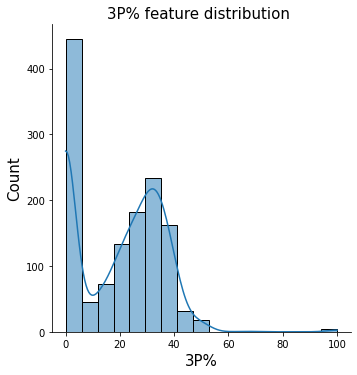

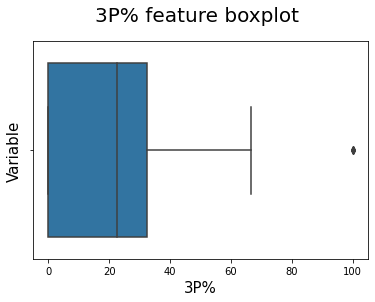

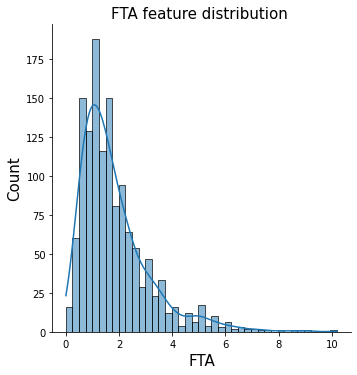

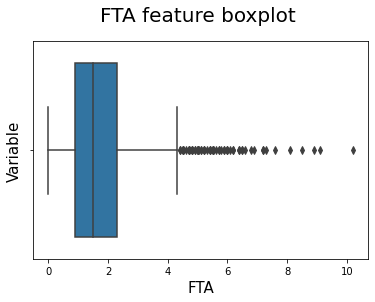

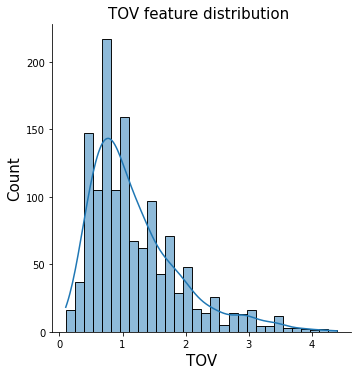

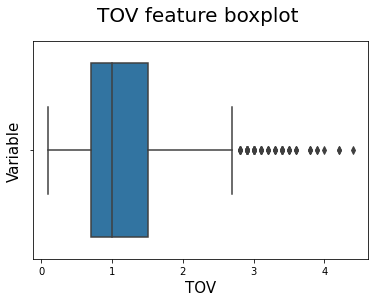

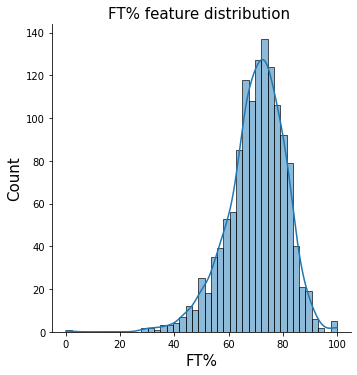

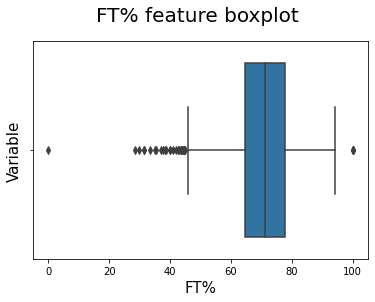

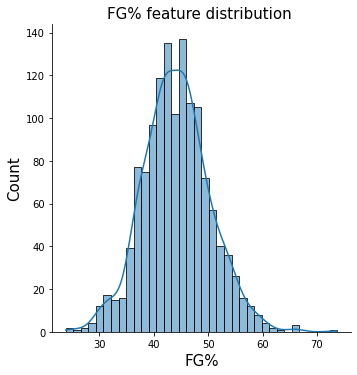

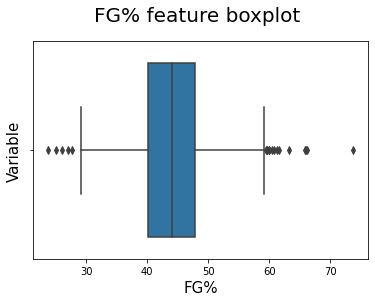

In [26]:
nba_rookie_dataset= {"name":"nba rookie", "path":"/data/notebook_files/data_sets/nba_rookie.csv",  "type": "binary_class" }


from pandas import read_csv
df = read_csv(nba_rookie_dataset["path"])
for col in ["3P%" , "FTA" , "TOV", "FT%", "FG%"]:
    plot_univariate_distribution(df[col], col, title=col+ " feature distribution ")
    plot_univariate_boxplot(df[col], col, title=col+ " feature boxplot ")
